In [1]:
import MySQLdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook,tqdm
import pickle
pd.set_option('max_row',1000)
pd.set_option('max_column',1000)

In [2]:
def read_and_drop():
    
    conn = MySQLdb.connect(host="127.0.0.1",
                                 user="root",
                                 passwd="root123",
                                 db="football",
                                 charset = 'utf8'
                        )
    # 从数据库读取数据
    leagues = pd.read_sql_query('select * from league',conn)
    match_stats = pd.read_sql_query('select * from match_stats', conn)
    matches = pd.read_sql_query('select * from matches', conn)
    teams = pd.read_sql_query('select * from team', conn)
    kickoff_handicaps = pd.read_sql_query('select * from kickoff_handicap',conn)
    
    # 删除无意义的字段
    to_drop_match_stats = ['create_time','update_time', 'first_half_time_corners','full_time_corners','full_time_goals','full_time_goals_against']
    match_stats = match_stats.drop(to_drop_match_stats, axis = 1)
    
    to_drop_matches = ['create_time','update_time', 'first_half_time_corners','full_time_corners']
    matches = matches.drop(to_drop_matches, axis = 1)
    
    to_drop_leagues = ['create_time','update_time','abbreviation','type','top']
    leagues = leagues.drop(to_drop_leagues, axis = 1)
    
    to_drop_teams = ['create_time','update_time']
    teams = teams.drop(to_drop_teams, axis = 1)
    
    to_drop_kickoff_handicaps = ['create_time','update_time','over_odds','under_odds']
    kickoff_handicaps = kickoff_handicaps.drop(to_drop_kickoff_handicaps, axis = 1)
    
    return matches, match_stats, leagues, teams, kickoff_handicaps


def data_cleaning(matches, match_stats, leagues, teams, kickoff_handicaps):
    '''
        DESC: 对每张表清洗数据，其中包括；
            1. 将分类变量转化为categorical类型，并提取code
            2. 合并表格
            3. 去除清洗过程中产生的多余字段
            4. 将字段转化为正确的数据类型
            
        Parameters:
            球赛数据需要的各类表格
            
        Returns:
            match_stats, 本表清洗过后合并的宽表，可以用来构造其他特征
    
    '''
    
    # women字段 one-hot encoding
    matches['women_cat'] = pd.Categorical(matches['women']).codes
    
    # match 表清洗， 与leagues表合并
    leagues.columns = ['league_id', 'league_name', 'league_type']
    matches = matches.drop(['league_type'], axis = 1).merge(leagues, on= 'league_id', how = 'left')
    clean_matches = matches[['id','league_id','women','women_cat','league_name','league_type']].copy()
    clean_matches.columns = ['match_id','league_id','women','women_cat','league_name','league_type']
    
    # match_stats表分类变量code提取
    match_stats['home_team_cat'] = pd.Categorical(match_stats['home_team']).codes
    match_stats['match_result_cat'] = pd.Categorical(match_stats['match_result']).codes
    match_stats['match_start_time'] = pd.to_datetime(match_stats['match_start_time'])
    
    # 总表字段重命名
    match_stats.columns = ['match_stats_id', 'attacks', 'dangerous_attacks', 'first_half_time_goals',
           'first_half_time_goals_against', 'home_team', 'league_id', 'match_id',
           'match_result', 'match_start_time', 'off_targets', 'on_targets',
           'red_cards', 'second_half_time_goals', 'second_half_time_goals_against',
           'shots', 'team_id', 'yellow_cards', 'home_team_cat',
           'match_result_cat']
    
    # match_stats与matches, teams， kickoffs 合并
    match_stats = match_stats.drop('league_id', axis = 1)
    match_stats = match_stats.merge(clean_matches, on = 'match_id', how = 'left')
    teams.columns = ['team_id','team_name']
    match_stats = match_stats.merge(teams, on = 'team_id', how = 'left')
    
    # pivot以后，两个盘口的数据变成字段，然后join
    kickoff_handicaps = kickoff_handicaps.pivot(index='match_id', columns='handicap_type', values='handicap_value')
    kickoff_handicaps.columns.name = None
    match_stats = match_stats.merge(kickoff_handicaps.reset_index(), on = 'match_id', how = 'left')
    
    match_stats['league_type_cat'] = pd.Categorical(match_stats['league_type']).codes
    
    # 将object字段转化为整数
    ints = ['match_id','team_id','league_id']
    for col in ints:
        match_stats[col] = match_stats[col].astype('int64')
    
    # 多分类变量 - one-hot encoding
    match_result_dummies = pd.get_dummies(match_stats['match_result_cat'],prefix='match_result_cat')    
    match_stats = pd.concat([match_stats, match_result_dummies], axis = 1)
        
    return match_stats.dropna()

In [3]:
matches, match_stats, leagues, teams, kickoff_handicaps = read_and_drop()
match_stats = data_cleaning(matches, match_stats, leagues, teams, kickoff_handicaps)
mapping_stats2league = {stats_id:league_id for stats_id, league_id  in match_stats[['match_stats_id','league_id']].values}

对于每一个match_id              
    - 找到两个team_id                
    - 找到一个match_start_time            
    - 在此match_start_time 之前               
        - 如果两个队都存在 >= T 场比赛：               
            - 增加一个对应关系：                          
            - match_id: [team_1 对应的 T 个match_stats_id], [team_2 对应的 T 个match_stats_id]                     

In [4]:
match_ids = np.load('match_ids.npy')
tower_inputs = np.load('tower_inputs.npy')
tower_inputs.shape, match_ids.shape

((277375, 2, 10, 16), (277375,))

In [5]:
def current_match_input_data(match_stats, match_ids, recreate = False):
    
    if recreate:
        mapping_matchid2teams = {}

        for match_id in tqdm(match_ids):
            cur_match = match_stats[match_stats['match_id'] == match_id]
            team_1, team_2 = cur_match['team_id'].values
            mapping_matchid2teams[match_id] = [team_1, team_2]
        open('mapping_matchid2teams.dic','wb').write(pickle.dumps(mapping_matchid2teams))
        
        
    mapping_matchid2teams = pickle.load(open('mapping_matchid2teams.dic','rb'))

    matchid2team1 = [(match_id, team_1) for match_id, [team_1, team_2] in mapping_matchid2teams.items()]
    team_1_cur_match = match_stats.copy().set_index(['match_id','team_id'])
    team_1_cur_match = team_1_cur_match.loc[matchid2team1,:]
    home_team_cat = team_1_cur_match.reset_index().set_index('match_id').loc[match_ids,:]['home_team_cat'].values

    sub_df_women = match_stats[match_stats['match_id'].isin(match_ids)].\
    drop_duplicates(subset=['match_id'])[['match_id','women_cat']]
    sub_df_women = sub_df_women.set_index('match_id')
    women_cat = sub_df_women.loc[match_ids,:]['women_cat'].values
    
    return home_team_cat, women_cat

In [6]:
home_team_cat, women_cat = current_match_input_data(match_stats, match_ids, recreate = False)

In [7]:
unique_league_ids = match_stats.copy().set_index('match_id').loc[match_ids,:]['league_id'].unique()
n_league_ids = len(unique_league_ids)
league_id_2_embed_id = {l_id:i for i, l_id in enumerate(unique_league_ids)}
embed_id_2_league_id = {v:k for k, v in league_id_2_embed_id.items()}
league_ids_inputs = match_stats.copy().drop_duplicates(subset = 'match_id').set_index('match_id').loc[match_ids,['league_id']].replace(league_id_2_embed_id)
league_embed_ids = league_ids_inputs['league_id'].values

In [8]:
y_1hot = match_stats.copy().drop_duplicates(subset = ['match_id']).set_index('match_id').loc[match_ids,:][['match_result_cat_0','match_result_cat_1','match_result_cat_2']].values
y = np.argmax(y_1hot, axis = 1)

In [9]:
data_filter = (y !=0)

------------------------------------------

In [10]:
team_1_history_inputs = tower_inputs[:,0,:,:] # N, T, D
team_2_history_inputs = tower_inputs[:,1,:,:] # N, T, D
team_1_history_inputs.shape, team_2_history_inputs.shape

((277375, 10, 16), (277375, 10, 16))

In [11]:
current_match_inputs = np.c_[home_team_cat, women_cat]

In [12]:
current_match_inputs.shape

(277375, 2)

In [13]:
league_embed_ids

array([  0,   1,   2, ...,  70, 586, 384])

In [14]:
team_1_history_inputs = team_1_history_inputs[data_filter,:,:]
team_2_history_inputs = team_2_history_inputs[data_filter,:,:]
current_match_inputs = current_match_inputs[data_filter,:]
y = y[data_filter] - 1
league_embed_ids = league_embed_ids[data_filter]

In [55]:
team_embedding = team_embedding[data_filter]

------------------------------------

### Preprocessing

In [52]:
import pickle
team_embedding = pickle.load(open('team_embedding.dic','rb'))
mapping_matchid2teams = pickle.load(open('mapping_matchid2teams.dic','rb'))
team_ids = np.unique([[*v] for k,v in mapping_matchid2teams.items()])
team_embedding = np.array([[team_embedding[v[0]], team_embedding[v[1]]] for k,v in mapping__matchid2teams.items()])

In [15]:
# 两队的历史数据，除了带cat的字段，其他都要标准化
cols_to_standardize = [0,1,2,3,4,5,6,7,8,9,12]
num_cols_history = np.stack([team_1_history_inputs,team_2_history_inputs]).reshape((-1,16))[:,cols_to_standardize]
history_num_means = num_cols_history.mean(axis = 0).reshape(1,1,-1)
history_num_stds = num_cols_history.std(axis = 0).reshape(1,1,-1)
team_1_history_inputs[:,:,cols_to_standardize] = (team_1_history_inputs[:,:,cols_to_standardize] - history_num_means) / history_num_stds
team_2_history_inputs[:,:,cols_to_standardize] = (team_2_history_inputs[:,:,cols_to_standardize] - history_num_means) / history_num_stds

------------------------------

In [16]:
from keras.layers import LSTM, Dense, Input, Embedding,Concatenate,Flatten,Dropout
from keras.models import Model
from keras import optimizers

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [78]:
M = 25
T = 10
D_his = 16
D_cur = 2
K = 1




team_1_input_tensor = Input(shape = (T,D_his)) # NTD
team_2_input_tensor = Input(shape = (T,D_his)) # NTD
history_lstm = LSTM(25) 
team_1_lstm_out = history_lstm(team_1_input_tensor) # M
team_2_lstm_out = history_lstm(team_2_input_tensor) # M
concat_layer = Concatenate(axis = -1)
context_output = concat_layer([team_1_lstm_out, team_2_lstm_out])
context_densor = Dense(20,activation = 'relu')
context_output = context_densor(context_output)

current_match_inputs_tensor = Input(shape = (D_cur,))
active_concat_layer = Concatenate(axis = -1)
active_concat_tensor = active_concat_layer([context_output, current_match_inputs_tensor])

league_cat_input_tensor = Input((1,))
league_embedding = Embedding(n_league_ids, M)
league_embd_tensor = league_embedding(league_cat_input_tensor)
league_embd_tensor = Flatten()(league_embd_tensor)


team_embedding_tensor = Input(shape = (2,))

league_active_concat_layer = Concatenate(axis = -1)
active_concat_tensor = league_active_concat_layer([active_concat_tensor, league_embd_tensor, team_embedding_tensor])
final_dense = Dense(20,activation = 'relu') 
active_concat_tensor = final_dense(active_concat_tensor)
active_concat_tensor = Dropout(0.35)(active_concat_tensor)
last_fianl_dense = Dense(K,activation = 'sigmoid')
active_concat_tensor = last_fianl_dense(active_concat_tensor)


model = Model([team_1_input_tensor, team_2_input_tensor, current_match_inputs_tensor, league_cat_input_tensor,team_embedding_tensor],
              active_concat_tensor)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 10, 16)       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 10, 16)       0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 25)           4200        input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 50)           0           lstm_2[0][0]               

In [79]:
# M = 25
# T = 10
# D_his = 16
# D_cur = 2
# K = 3

# team_1_input_tensor = Input(shape = (T,D_his)) # NTD
# team_2_input_tensor = Input(shape = (T,D_his)) # NTD
# history_lstm = LSTM(25) 
# team_1_lstm_out = history_lstm(team_1_input_tensor) # M
# team_2_lstm_out = history_lstm(team_2_input_tensor) # M
# concat_layer = Concatenate(axis = -1)
# context_output = concat_layer([team_1_lstm_out, team_2_lstm_out])
# context_densor = Dense(20,activation = 'relu')
# context_output = context_densor(context_output)

# current_match_inputs_tensor = Input(shape = (D_cur,))
# active_concat_layer = Concatenate(axis = -1)
# active_concat_tensor = active_concat_layer([context_output, current_match_inputs_tensor])

# # league_cat_input_tensor = Input((1,))
# # league_embedding = Embedding(n_league_ids, M)
# # league_embd_tensor = league_embedding(league_cat_input_tensor)
# # league_embd_tensor = Flatten()(league_embd_tensor)

# # league_active_concat_layer = Concatenate(axis = -1)
# # active_concat_tensor = league_active_concat_layer([active_concat_tensor, league_embd_tensor])
# final_dense = Dense(K,activation = 'softmax') 
# active_concat_tensor = final_dense(active_concat_tensor)

# model = Model([team_1_input_tensor, team_2_input_tensor, current_match_inputs_tensor],active_concat_tensor)
# model.summary()

In [80]:
from keras.utils import plot_model

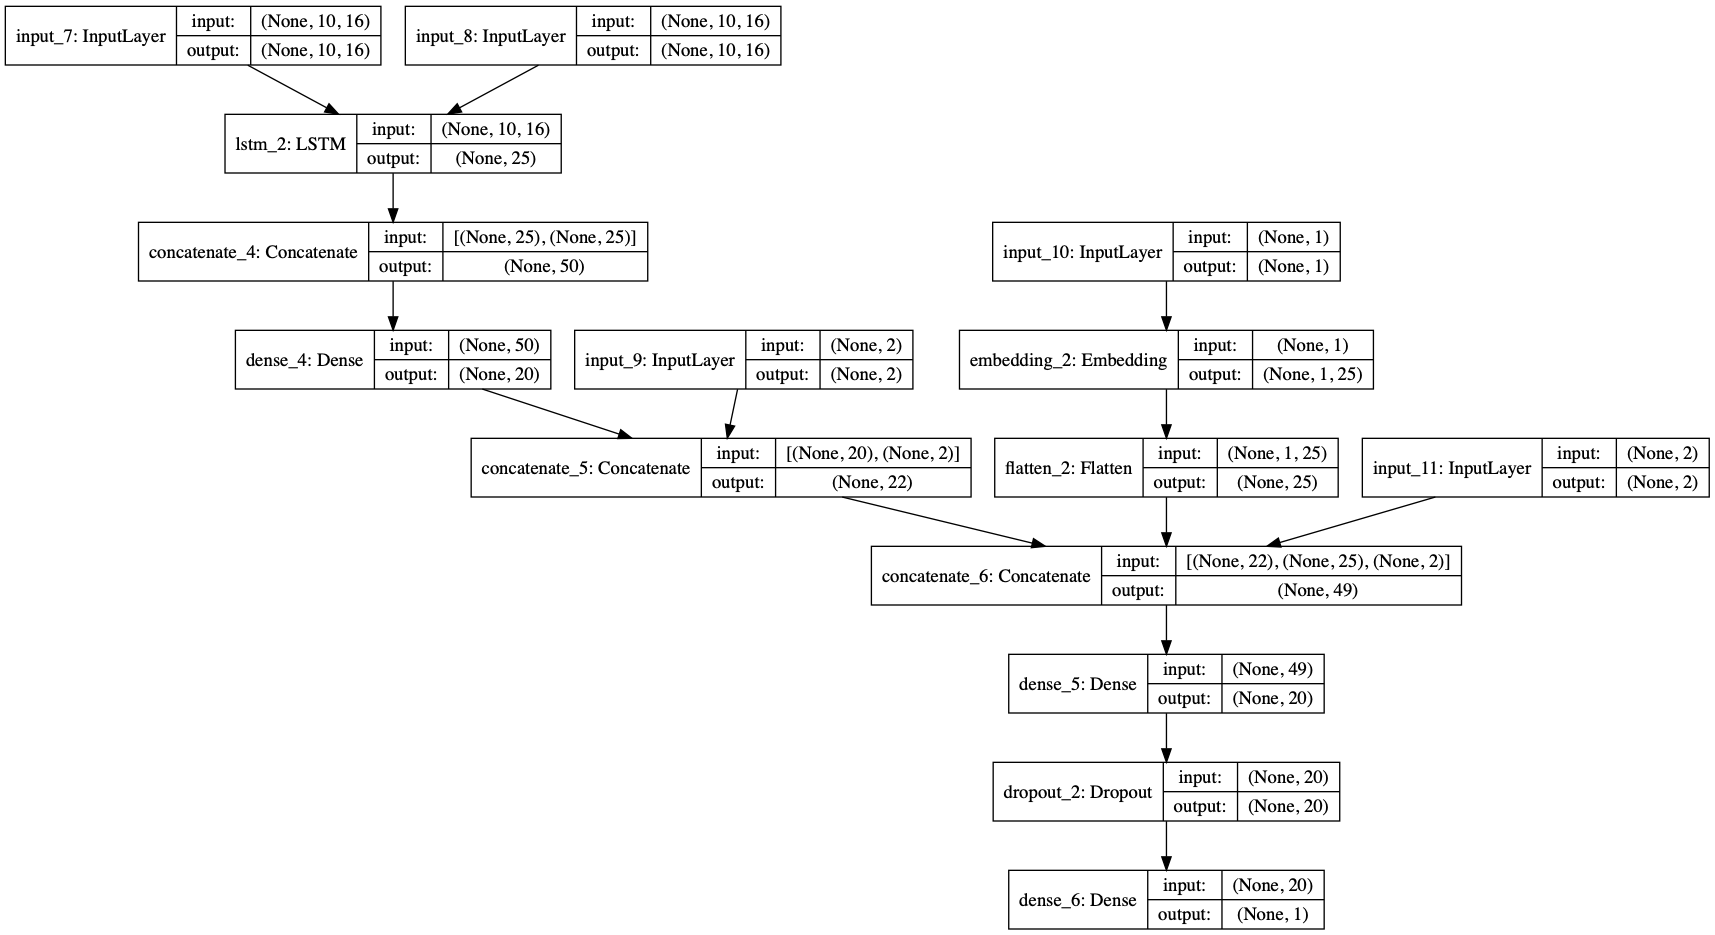

In [81]:
plot_model(model,show_shapes=True)

In [82]:
team_1_history_inputs.shape, team_2_history_inputs.shape

((209808, 10, 16), (209808, 10, 16))

In [83]:
current_match_inputs.shape

(209808, 2)

In [84]:
league_embed_ids.shape

(209808,)

In [85]:
y.shape

(209808,)

In [86]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

In [89]:
history = model.fit([team_1_history_inputs, team_2_history_inputs,current_match_inputs,league_embed_ids, team_embedding],y,batch_size = 256,epochs = 1,validation_split=0.05)

Train on 199317 samples, validate on 10491 samples
Epoch 1/1
199317/199317 [==============================] - 9s 43us/step - loss: 0.5631 - accuracy: 0.7073 - val_loss: 0.6326 - val_accuracy: 0.6509


In [90]:
preds = model.predict([team_1_history_inputs, team_2_history_inputs,current_match_inputs,league_ids_inputs,team_embedding])

In [91]:
from sklearn.metrics import confusion_matrix,roc_auc_score

In [104]:
cri = 0.60

预测team1胜利的情况

In [105]:
confuse = pd.crosstab((preds > cri).flatten().astype(int),y)
confuse

col_0,0,1
row_0,,
0,59906,41994
1,26168,81740


预测team2胜利的情况

失败概率

In [106]:
confuse.iloc[1,0] / confuse.iloc[1].sum()

0.24250287281758534

In [107]:
confuse.sum(axis = 1)[1] / confuse.sum().sum()

0.5143178525127736

能去玩儿38.2%的游戏

In [108]:
confuse = pd.crosstab((preds >(1-cri)).flatten().astype(int),y)
confuse

col_0,0,1
row_0,,
0,29608,10706
1,56466,113028


失败概率

In [109]:
confuse.iloc[0,1] / confuse.iloc[0].sum()

0.2655653122984571

In [110]:
confuse.sum(axis = 1)[0] / confuse.sum().sum()

0.19214710592541753

能去玩儿10.2%的游戏

### 你去降低自己的概率阈值的时候，风险就会相应的增加，但是可玩儿的游戏也会增加，需要一个平衡
### 所以我们能去玩儿大概48%的游戏，最后有一个75%多的一个precision，如果预测胜负能赚钱，那就赚钱了
### 现在是在验证数据集上看是否过拟合，基本没有过拟合现象，在出来一个测试集，就完美了